# Demo

Demo code for latent-space-data-assimilation using a 2D multi-Gaussian field dataset and a linear forward model as the simulator.

For nonlinear forward model, simply replace "dataset.simulator" with the nonlinear simulation function.

In [2]:
import random
import string
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import numpy.matlib as npmatlib
%matplotlib inline

import dataloader
import util
import autoencoderdual
import esmda

class_names = ['Meandering', 'Anastomosing-0', 
               'Anastomosing-135', 'Anastomosing-90', 'Anastomosing-45']
sc_index = class_names.index('Anastomosing-135')

#load data and filter by scenario
dataset = dataloader.DataLoader(simulator=np.load('G100.npy'), scenario = sc_index, verbose=True)
x_train, x_test, y_reg_train, y_reg_test = dataset.load_data()

#load trained LSDA architecture, to retrain set "load=False", ~2hr on NVIDIA RTX2080Ti
LSDA = autoencoderdual.Autoencoder(x_train, y_reg_train, variational=False)
LSDA.train_autoencoder_dual_LSF(epoch=600, load=True)

Running simulation  0
Running simulation  1
Running simulation  2
Running simulation  3
Running simulation  4
Running simulation  5
Running simulation  6
Running simulation  7
Running simulation  8
Running simulation  9
Running simulation  10
Running simulation  11
Running simulation  12
Running simulation  13
Running simulation  14
Running simulation  15
Running simulation  16
Running simulation  17
Running simulation  18
Running simulation  19
Running simulation  20
Running simulation  21
Running simulation  22
Running simulation  23
Running simulation  24
Running simulation  25
Running simulation  26
Running simulation  27
Running simulation  28
Running simulation  29
Running simulation  30
Running simulation  31
Running simulation  32
Running simulation  33
Running simulation  34
Running simulation  35
Running simulation  36
Running simulation  37
Running simulation  38
Running simulation  39
Running simulation  40
Running simulation  41
Running simulation  42
Running simulation  4

Running simulation  346
Running simulation  347
Running simulation  348
Running simulation  349
Running simulation  350
Running simulation  351
Running simulation  352
Running simulation  353
Running simulation  354
Running simulation  355
Running simulation  356
Running simulation  357
Running simulation  358
Running simulation  359
Running simulation  360
Running simulation  361
Running simulation  362
Running simulation  363
Running simulation  364
Running simulation  365
Running simulation  366
Running simulation  367
Running simulation  368
Running simulation  369
Running simulation  370
Running simulation  371
Running simulation  372
Running simulation  373
Running simulation  374
Running simulation  375
Running simulation  376
Running simulation  377
Running simulation  378
Running simulation  379
Running simulation  380
Running simulation  381
Running simulation  382
Running simulation  383
Running simulation  384
Running simulation  385
Running simulation  386
Running simulati

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 500)               1024500   
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 500)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 300)               150300    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 300)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 200)               60200     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 200)               0         
__________

In [108]:
#get variables for LSDA
zm_test = LSDA.m2zm.predict(x_test)
zd_test = LSDA.d2zd.predict(y_reg_test)

In [109]:
#lsda workflow 
ref_case = 13
N_a = 4
alpha = [9e17, 8e17, 7e17, 6e17]

#data: in practice, remove/hide the ref_case from the ensemble
d_obs = y_reg_test[ref_case:ref_case+1, :].T

#call esmda method
esmda_method = esmda.ESMDA(ref_case, d_obs, LSDA, zm_test, zd_test)
Ensemble, Ensemble_d = esmda_method.assimilate(N_a, alpha)

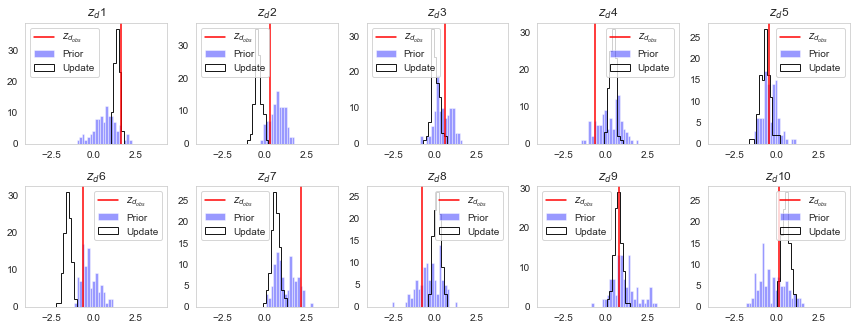

In [110]:
#plot for all latent variables
binmax = np.max(Ensemble_d[0])
binmin = np.min(Ensemble_d[0])
bb2 = np.linspace(binmin, binmax, 50)

f = plt.figure(figsize=(12, 9))
for i in range(10):
    plt.subplot(4, 5, i+1)
    plt.hist(Ensemble_d[0][i, :].flatten(), color='blue', alpha=0.4, bins=bb2, density=False, label="Prior")
    plt.hist(Ensemble_d[3][i, :].flatten(), color='blue', alpha=0.9, edgecolor='black', histtype='step', bins=bb2, density=False, label="Update")
    plt.axvline(x=zd_test[ref_case:ref_case+1, i], c='r', label="$z_{d_{obs}}$")
    plt.grid(False)
    plt.title('$z_{d}$'+str(i+1))
    plt.legend()
f.tight_layout()
f.savefig('readme/test_zds_demo.png')

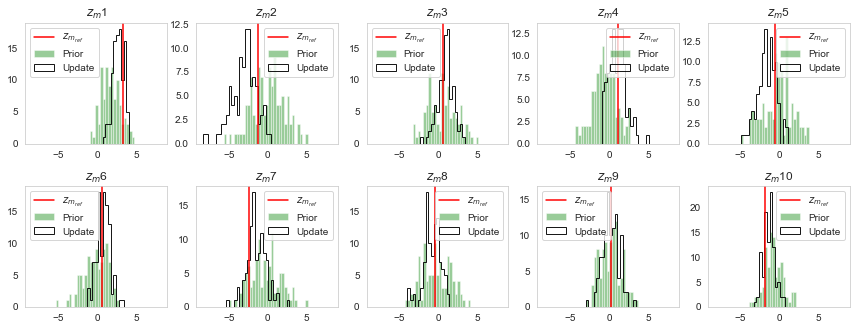

In [111]:
#plot for all latent variables
binmax = np.max(Ensemble[0])
binmin = np.min(Ensemble[0])
bb2 = np.linspace(binmin, binmax, 50)

f = plt.figure(figsize=(12, 9))
for i in range(0, 10):
    plt.subplot(4, 5, i+1)
    plt.hist(Ensemble[0][i, :].flatten(), color='green', alpha=0.4, bins=bb2, density=False, label="Prior")
    plt.hist(Ensemble[3][i, :].flatten(), color='green', alpha=0.9, edgecolor='black', histtype='step', bins=bb2, density=False, label="Update")
    plt.axvline(x=zm_test[ref_case:ref_case+1, i], c='r', label="$z_{m_{ref}}$")
    plt.grid(False)
    plt.title('$z_{m}$'+str(i+1))
    plt.legend()
f.tight_layout()
f.savefig('readme/test_zms_demo.png')

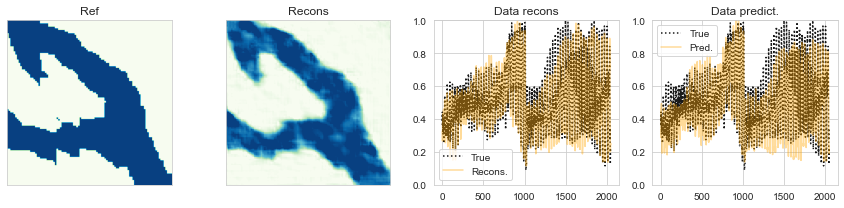

In [112]:
m_ref_hat = np.squeeze(LSDA.zm2m.predict(zm_test[ref_case:ref_case+1, :]))
y_reg_test_hat = LSDA.d2d.predict(y_reg_test)
y_reg_test_pred = LSDA.m2d.predict(x_test)

#model (i.e. reference case)
f = plt.figure(figsize=(12,3))
plt.subplot(1, 4, 1)
plt.imshow(x_test[ref_case], cmap=plt.cm.GnBu, vmin=0, vmax=1, aspect='equal')
plt.xticks([]), plt.yticks([])
plt.title("Ref")

#model reconstruction (i.e. reference case)
plt.subplot(1, 4, 2)
plt.imshow(m_ref_hat, cmap=plt.cm.GnBu, vmin=0, vmax=1, aspect='equal')
plt.xticks([]), plt.yticks([])
plt.title("Recons")

#data and data reconstruction
ax = f.add_subplot(1, 4, 3)
plt.plot(y_reg_test[ref_case, :], ls=':', c='k', label='True', alpha=0.9)
plt.plot(y_reg_test_hat[ref_case, :], c='orange', label='Recons.', alpha=0.4)
plt.ylim([0, 1])
plt.title("Data recons")
plt.legend()

#data and data regression (i.e. forecast)
ax = f.add_subplot(1, 4, 4)
plt.plot(y_reg_test[ref_case, :], ls=':', c='k', label='True', alpha=0.9)
plt.plot(y_reg_test_pred[1][ref_case, :], c='orange', label='Pred.', alpha=0.4)
plt.ylim([0, 1])
plt.title("Data predict.")
plt.legend()

plt.tight_layout()
f.savefig('readme/test_sigs_ref_regs_demo.png')

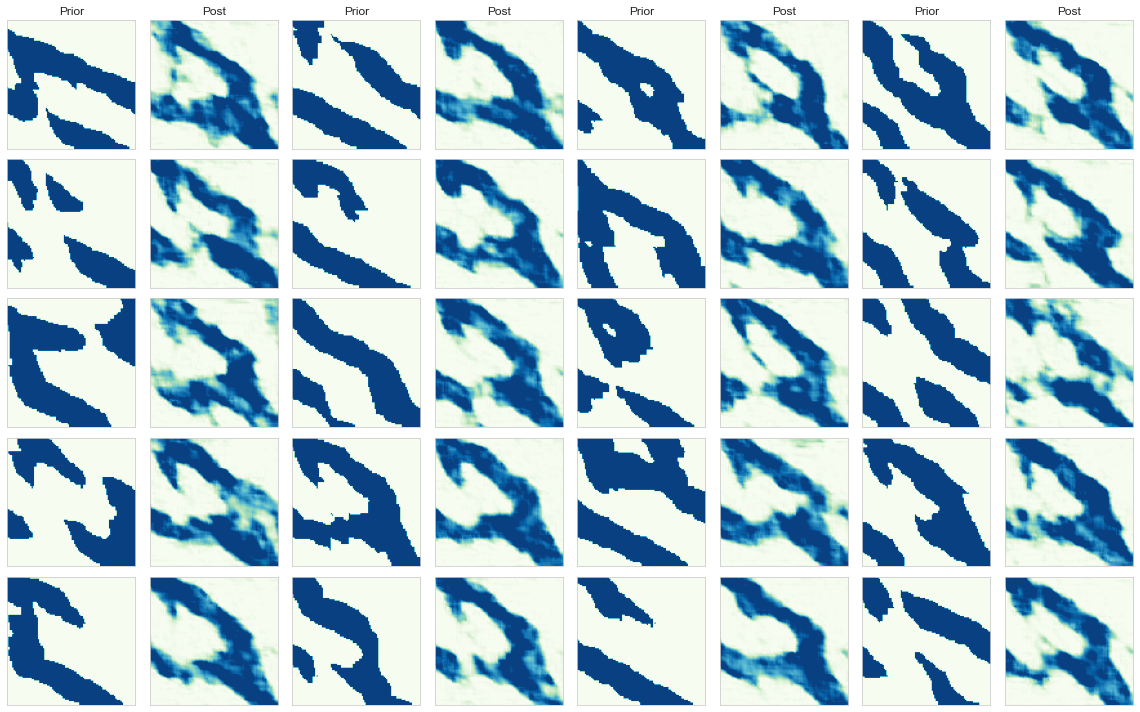

In [113]:
posteriors = LSDA.zm2m.predict(Ensemble[3].T)
    
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
    
f = plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plt.grid(False)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.squeeze(x_test[i]), cmap=plt.cm.GnBu, vmin=0, vmax=1) 
    if i < 4:
        plt.title("Prior")
    
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plt.grid(False)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.squeeze(posteriors[i]), cmap=plt.cm.GnBu, vmin=0, vmax=1)
    if i < 4:
        plt.title("Post")
    
plt.tight_layout()
plt.show()

f.savefig('readme/test_prior_posts_demo.png')

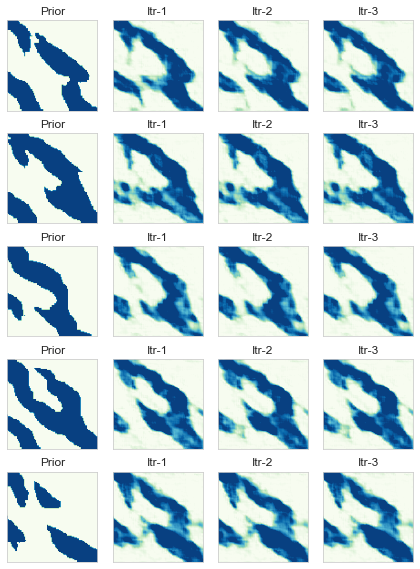

In [114]:
#display figures with iterations

img_itr1 = LSDA.zm2m.predict(Ensemble[1].T)
img_itr2 = LSDA.zm2m.predict(Ensemble[2].T)
img_itr3 = LSDA.zm2m.predict(Ensemble[3].T)

f = plt.figure(figsize=(6, 8))
for count, i in enumerate([7, 15, 17, 3, 4]):

    plt.subplot(5, 4, (4*(count))+1)
    plt.grid(False)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.squeeze(x_test[i]), cmap=plt.cm.GnBu, vmin=0, vmax=1) 
    plt.title("Prior")
    
    plt.subplot(5, 4, (4*(count))+2)
    plt.grid(False)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.squeeze(img_itr1[i]), cmap=plt.cm.GnBu, vmin=0, vmax=1) 
    plt.title("Itr-1")
    
    plt.subplot(5, 4, (4*(count))+3)
    plt.grid(False)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.squeeze(img_itr2[i]), cmap=plt.cm.GnBu, vmin=0, vmax=1) 
    plt.title("Itr-2")
    
    plt.subplot(5, 4, (4*(count))+4)
    plt.grid(False)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.squeeze(img_itr3[i]), cmap=plt.cm.GnBu, vmin=0, vmax=1) 
    plt.title("Itr-3")
    
plt.tight_layout()
f.savefig('readme/test_prior_posts_itrs_demo.png')

In [115]:
#mean and variance of prior and posterior

def plotmvar(data1, data2, name=[]):
    f = plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(data1), cmap=plt.cm.GnBu, vmin=0, vmax=1, aspect='equal')
    plt.xticks([]), plt.yticks([])
    plt.title(name+"_$\mu$")

    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(data2), cmap=plt.cm.GnBu, vmin=0, vmax=0.25)
    plt.xticks([]), plt.yticks([])
    plt.title(name+"_$\sigma$")
    plt.tight_layout()
    f.savefig("readme/test_mean_var_"+name+"_demo.png")

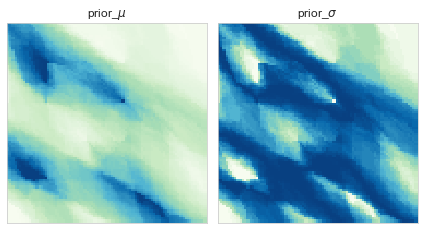

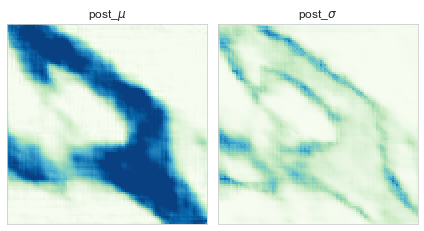

In [116]:
plotmvar(np.mean(x_test, axis=0), np.var(x_test, axis=0), name="prior")
plotmvar(np.mean(posteriors, axis=0), np.var(posteriors, axis=0), name="post")

In [117]:
#take cut off (0 and 1, cutoff at 0.5 for discrettization)
posteriors = np.where(posteriors<0.5, 0, 1)

#run forward simulation on the posteriors
G = np.load('G100.npy')
y_dim = G.shape[-1]
D_posteriors = np.zeros([posteriors.shape[0], y_dim])
for i in range(D_posteriors.shape[0]):
    D_posteriors[i:i+1, :] = np.reshape((posteriors[i:i+1, :, :, 0]), [1, posteriors.shape[1]*posteriors.shape[2]])@G
    
#normalize using the same normalization factor for the training dataset
D_posteriors = dataset.normalize_data(D_posteriors)

#data from posteriors (using proxy)
D_posteriors_proxy =  LSDA.zd2d.predict(Ensemble_d[-1].T)

D:\13108\anaconda3\envs\Py36\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
D:\13108\anaconda3\envs\Py36\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


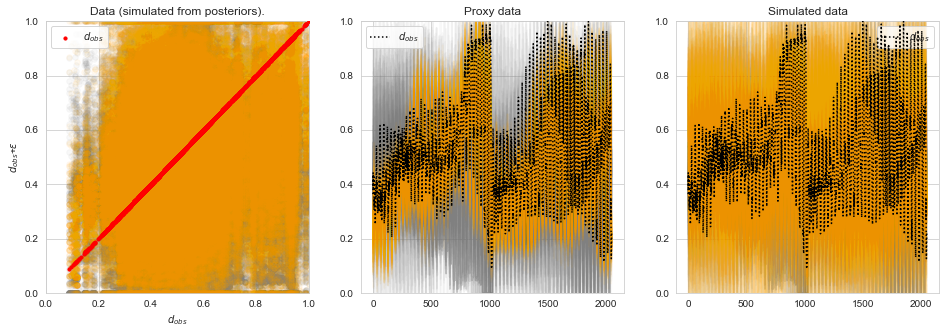

In [118]:
#view posteriors simulated data
f = plt.figure(figsize=(16, 5))
ax = f.add_subplot(1, 3, 1)
plt.scatter(y_reg_test[ref_case,:].flatten(), y_reg_test[ref_case,:].flatten(), s=10, color='red', alpha=1, label="$d_{obs}$", zorder=20)
for i in range(100):
    plt.scatter(y_reg_test[ref_case,:].flatten(), y_reg_test[i,:].flatten(), s=30, color='gray', alpha=0.05)
for i in range(100):
    plt.scatter(y_reg_test[ref_case,:].flatten(), D_posteriors[i,:].flatten(), s=30, color='orange', alpha=0.05)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("$d_{obs}$")
plt.ylabel("$d_{obs}$"+"+$\epsilon$")
plt.legend()
plt.title('Data (simulated from posteriors).')

ax = f.add_subplot(1, 3, 2)
timesteps = np.linspace(0, 2048-1, 2048)
plt.plot(timesteps, y_reg_test[ref_case,:], ls=':', c='k', alpha=1, label="$d_{obs}$", zorder=20)
for i in range(100):
    plt.plot(timesteps, y_reg_test[i,:], color='gray', alpha=0.05)
for i in range(100):
    plt.plot(timesteps, D_posteriors_proxy[i,:], color='orange', alpha=0.05)
plt.ylim([0, 1])
plt.title('Proxy data')
plt.legend()

ax = f.add_subplot(1, 3, 3)
timesteps = np.linspace(0, 2048-1, 2048)
plt.plot(timesteps, y_reg_test[ref_case,:], ls=':', c='k', alpha=1, label="$d_{obs}$", zorder=20)
for i in range(100):
    plt.plot(timesteps, y_reg_test[i,:], color='gray', alpha=0.05)
for i in range(100):
    plt.plot(timesteps, D_posteriors[i,:], color='orange', alpha=0.05)
plt.ylim([0, 1])
plt.title('Simulated data')
plt.legend()

f.savefig('readme/test_d_post_demo.png')